In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import matplotlib.pyplot as plt

In [5]:
features = ['header','shotType_OtherBodyPart','situation_DirectFreekick','situation_FromCorner',
            'situation_OpenPlay','situation_Penalty','situation_SetPiece','distance_to_goal','shot_angle','preferred_foot_shot']

In [ ]:
spark = SparkSession.builder.appName("features").getOrCreate()

In [6]:
# using these features train a logistic regression model
from xG_training import ModelTrainer
import xG_preprocessing as xG_pre

In [ ]:
hdfs_path = "hdfs://localhost:9000/big-data/shot_data.csv"

# Load the CSV file into a DataFrame
dfs = spark.read.csv(hdfs_path, header=True, inferSchema=True)

In [7]:
train_data, test_data = xG_pre.pre_training(dfs, features,0.7)
log_reg = ModelTrainer(train_data,test_data,max_iter=100)

In [9]:
from xG_evaluation import ModelEvaluation
from pyspark.sql.functions import col, when 

In [10]:
predictions = log_reg.predictions 
predictions = xG_pre.goal_proba(predictions)
predictions = predictions.withColumn('sb_prediction', when(col('xG') >= 0.5, 1).otherwise(0))
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'xG','goal_probability',model_type='regression')

In [ ]:
precision = []
recall = []
for threshold in thresholds:
    if threshold % 0.1 == 0:
        print(threshold)
    df_pr = predictions.withColumn("predicted",
                                   when(col("goal_probability")>=lit(threshold),
                                        lit(1)).otherwise(lit(0)))
    TP = df_pr.filter((col('predicted')==1)& (col("sb_prediction")==1)).count()
    FP = df_pr.filter((col('predicted')==1)& (col("sb_prediction")==0)).count()
    FN = df_pr.filter((col('predicted')==0)& (col("sb_prediction")==1)).count()

    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    precision.append(prec)
    recall.append(rec)

0.0
0.2
0.4
0.8


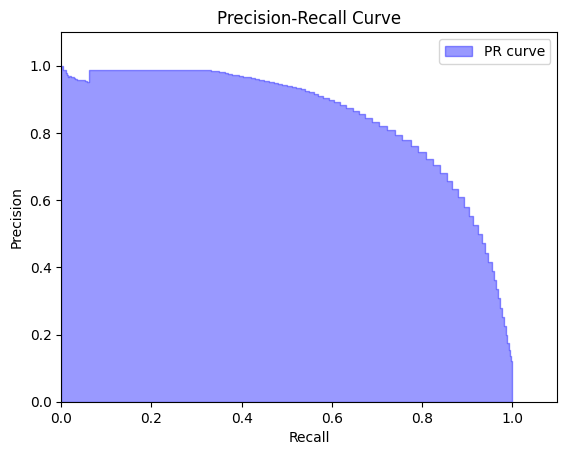

In [99]:
plt.fill_between(recall,precision, step='post',alpha=0.4,color='blue',label='PR curve')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [100]:
me.get_all_metrics()

{'Accuracy': 90.11,
 'Precision': 67.69,
 'Recall': 19.87,
 'Sensitivity': 19.87,
 'Specificity': 98.82,
 'F1': 30.72,
 'FPR': 1.18,
 'FNR': 80.13}

In [101]:
me_sb.get_all_metrics()

{'Accuracy': 97.42,
 'Precision': 92.15,
 'Recall': 56.14,
 'Sensitivity': 56.14,
 'Specificity': 99.73,
 'F1': 69.78,
 'FPR': 0.27,
 'FNR': 43.86}

In [102]:
me_r.get_all_metrics()

{'MSE': 0.00771, 'RMSE': 0.0878, 'MAE': 0.04849, 'R2': 71.59}